In [3]:
# LSTM

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')

# TensorFlow/Keras
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# 한글 폰트
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 1. 데이터 로드

df = pd.read_csv('../processed_data/processed_features.csv')

print(f"크기: {df.shape}")
print(df.head())

크기: (2156, 36)
                  file   ch1_rms  ch1_peak   ch1_std  ch1_kurtosis   ch2_rms  \
0  2003.10.22.12.06.24  0.124614     0.720  0.081122      1.069717  0.117493   
1  2003.10.22.12.09.13  0.123811     0.654  0.079515      1.162128  0.116833   
2  2003.10.22.12.14.13  0.125246     0.623  0.080217      0.986819  0.118384   
3  2003.10.22.12.19.13  0.125197     0.598  0.080825      1.034839  0.119005   
4  2003.10.22.12.24.13  0.125618     0.623  0.082034      1.110728  0.119688   

   ch2_peak   ch2_std  ch2_kurtosis   ch3_rms  ...  ch7_peak   ch7_std  \
0     0.701  0.070648      3.066925  0.130455  ...     0.413  0.060085   
1     0.581  0.069529      2.001798  0.131490  ...     0.420  0.059420   
2     0.549  0.069464      1.969725  0.131906  ...     0.396  0.059968   
3     0.535  0.071265      1.746089  0.131614  ...     0.393  0.059915   
4     0.537  0.072153      1.181742  0.130779  ...     0.376  0.059255   

   ch7_kurtosis   ch8_rms  ch8_peak   ch8_std  ch8_kurtosis

label
0    1507
1     649
Name: count, dtype: int64

비율:
label
0    0.69898
1    0.30102
Name: proportion, dtype: float64


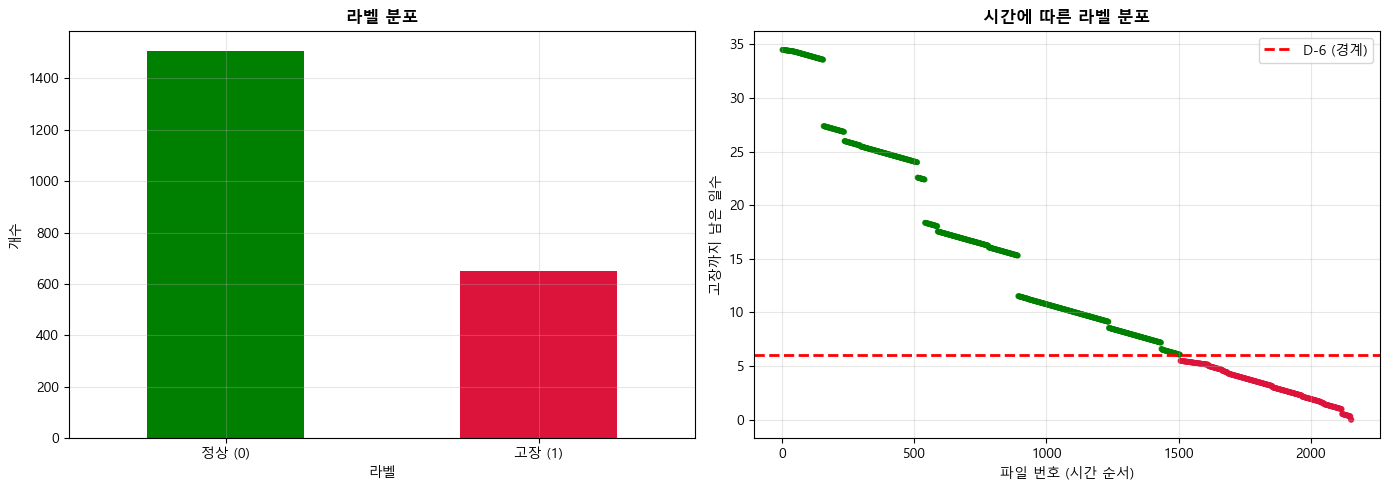

   정상 샘플: 1507개
   고장 샘플: 649개


In [4]:
# 2. 라벨 생성

# 방법: 고장 D-6일 이내면 고장(1), 아니면 정상(0)
threshold_days = 6

df['label'] = (df['days_to_failure'] <= threshold_days).astype(int)

# 라벨 분포 확인
print(df['label'].value_counts())
print(f"\n비율:")
print(df['label'].value_counts(normalize=True))

# 시각화
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 라벨 분포
ax1 = axes[0]
df['label'].value_counts().plot(kind='bar', ax=ax1, color=['green', 'crimson'])
ax1.set_title('라벨 분포', fontsize=12, fontweight='bold')
ax1.set_xlabel('라벨')
ax1.set_ylabel('개수')
ax1.set_xticklabels(['정상 (0)', '고장 (1)'], rotation=0)
ax1.grid(True, alpha=0.3)

# 시간에 따른 라벨
ax2 = axes[1]
x = range(len(df))
colors = ['green' if label == 0 else 'crimson' for label in df['label']]
ax2.scatter(x, df['days_to_failure'], c=colors, alpha=0.5, s=10)
ax2.axhline(y=threshold_days, color='red', linestyle='--', linewidth=2, 
            label=f'D-{threshold_days} (경계)')
ax2.set_title('시간에 따른 라벨 분포', fontsize=12, fontweight='bold')
ax2.set_xlabel('파일 번호 (시간 순서)')
ax2.set_ylabel('고장까지 남은 일수')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"   정상 샘플: {(df['label']==0).sum()}개")
print(f"   고장 샘플: {(df['label']==1).sum()}개")

특성 컬럼: 32개

정상 데이터: 1507개
고장 데이터: 649개

분할 완료:
  Train: (1508, 37)
  Val:   (323, 37)
  Test:  (325, 37)

라벨 분포:
  Train - 정상: 1054, 고장:  454 (30.1%)
  Val   - 정상:  226, 고장:   97 (30.0%)
  Test  - 정상:  227, 고장:   98 (30.2%)


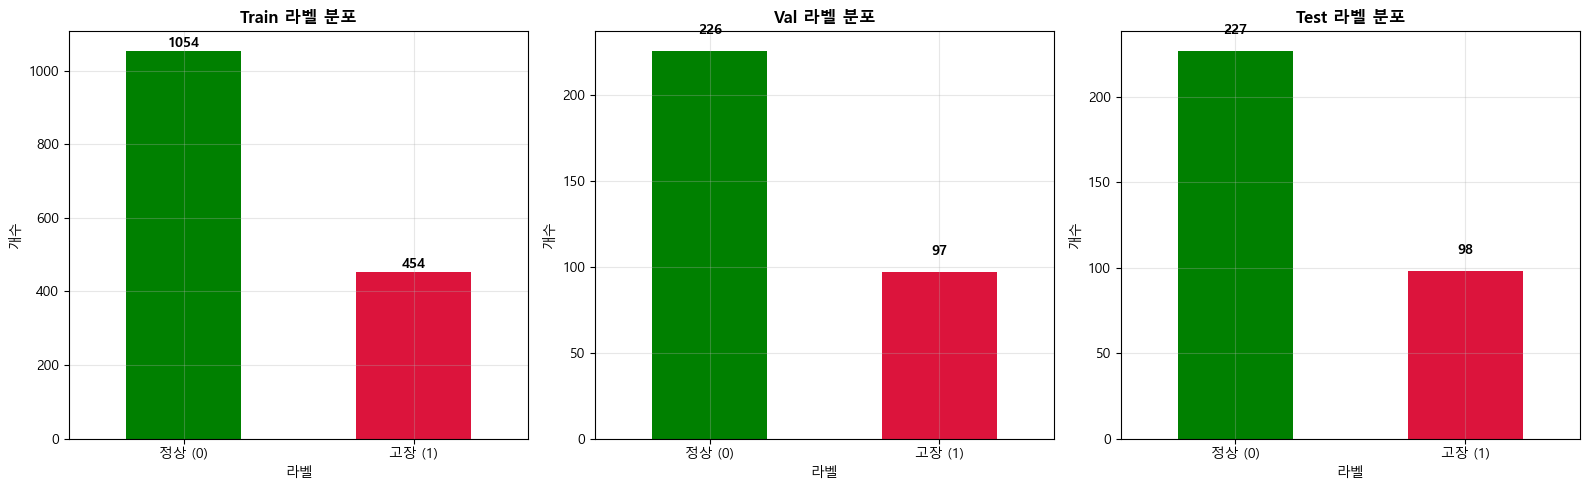

In [5]:
# 3. Train/Val/Test 분할 (계층적 분할)

# 특성 컬럼 선택
feature_cols = [col for col in df.columns if col.startswith('ch')]
print(f"특성 컬럼: {len(feature_cols)}개")

# 시계열 불균형 문제
# -> 정상 데이터: 초반 집중
# -> 고장 데이터: 후반 집중
# = 시간 순서 분할 시 Train에 고장 샘플 없음
# 해결책: 계층적 분할 (각 클래스별로 70/15/15)")

# 정상과 고장 데이터 분리
normal_data = df[df['label']==0].copy()
failure_data = df[df['label']==1].copy()

print(f"\n정상 데이터: {len(normal_data)}개")
print(f"고장 데이터: {len(failure_data)}개")

# 각각 70/15/15 분할
def split_data(data, train_ratio=0.7, val_ratio=0.15):
    n = len(data)
    train_end = int(n * train_ratio)
    val_end = train_end + int(n * val_ratio)
    
    train = data.iloc[:train_end]
    val = data.iloc[train_end:val_end]
    test = data.iloc[val_end:]
    
    return train, val, test

normal_train, normal_val, normal_test = split_data(normal_data)
failure_train, failure_val, failure_test = split_data(failure_data)

# 합치기
train_data = pd.concat([normal_train, failure_train], ignore_index=True)
val_data = pd.concat([normal_val, failure_val], ignore_index=True)
test_data = pd.concat([normal_test, failure_test], ignore_index=True)

# 섞기 (선택)
train_data = train_data.sample(frac=1, random_state=42).reset_index(drop=True)
val_data = val_data.sample(frac=1, random_state=42).reset_index(drop=True)
test_data = test_data.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"\n분할 완료:")
print(f"  Train: {train_data.shape}")
print(f"  Val:   {val_data.shape}")
print(f"  Test:  {test_data.shape}")

# 라벨 분포
print(f"\n라벨 분포:")
print(f"  Train - 정상: {(train_data['label']==0).sum():4d}, 고장: {(train_data['label']==1).sum():4d} ({(train_data['label']==1).sum()/len(train_data)*100:.1f}%)")
print(f"  Val   - 정상: {(val_data['label']==0).sum():4d}, 고장: {(val_data['label']==1).sum():4d} ({(val_data['label']==1).sum()/len(val_data)*100:.1f}%)")
print(f"  Test  - 정상: {(test_data['label']==0).sum():4d}, 고장: {(test_data['label']==1).sum():4d} ({(test_data['label']==1).sum()/len(test_data)*100:.1f}%)")

# 시각화
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

for idx, (name, data) in enumerate([('Train', train_data), ('Val', val_data), ('Test', test_data)]):
    ax = axes[idx]
    
    data['label'].value_counts().plot(kind='bar', ax=ax, 
                                       color=['green', 'crimson'])
    ax.set_title(f'{name} 라벨 분포', fontsize=12, fontweight='bold')
    ax.set_xlabel('라벨')
    ax.set_ylabel('개수')
    ax.set_xticklabels(['정상 (0)', '고장 (1)'], rotation=0)
    ax.grid(True, alpha=0.3)
    
    # 값 표시
    for i, v in enumerate(data['label'].value_counts()):
        ax.text(i, v + 10, str(v), ha='center', fontweight='bold')

plt.tight_layout()
plt.show()


In [7]:
# 4. 시계열 윈도우 생성

print("\n시계열 윈도우 생성")
print("-" * 60)

# 윈도우 크기 설정
window_size = 10  # 과거 10개 시점으로 예측

# 윈도우 크기: 과거 {window_size}일 데이터로 오늘 예측

# 윈도우 생성 함수
def create_sequences(data, feature_cols, window_size):
    """
    시계열 윈도우 생성
    
    입력:
    - data: DataFrame
    - feature_cols: 특성 컬럼 리스트
    - window_size: 윈도우 크기
    
    출력:
    - X: (samples, window_size, features) 3D 배열
    - y: (samples,) 라벨
    """
    X = []
    y = []
    
    # timestamp로 정렬 (시간 순서 보장)
    data = data.sort_values('timestamp').reset_index(drop=True)
    
    # 슬라이딩 윈도우
    for i in range(len(data) - window_size):
        # 과거 window_size개 데이터
        window = data.iloc[i:i+window_size][feature_cols].values
        
        # 예측 대상 (window 다음 시점)
        label = data.iloc[i+window_size]['label']
        
        X.append(window)
        y.append(label)
    
    return np.array(X), np.array(y)

# 각 세트별로 윈도우 생성
X_train, y_train = create_sequences(train_data, feature_cols, window_size)
X_val, y_val = create_sequences(val_data, feature_cols, window_size)
X_test, y_test = create_sequences(test_data, feature_cols, window_size)

print(f"\nTrain:")
print(f"  X_train: {X_train.shape} (samples, timesteps, features)")
print(f"  y_train: {y_train.shape}")
print(f"  고장 비율: {y_train.sum() / len(y_train) * 100:.1f}%")

print(f"\nVal:")
print(f"  X_val: {X_val.shape}")
print(f"  y_val: {y_val.shape}")
print(f"  고장 비율: {y_val.sum() / len(y_val) * 100:.1f}%")

print(f"\nTest:")
print(f"  X_test: {X_test.shape}")
print(f"  y_test: {y_test.shape}")
print(f"  고장 비율: {y_test.sum() / len(y_test) * 100:.1f}%")



시계열 윈도우 생성
------------------------------------------------------------

Train:
  X_train: (1498, 10, 32) (samples, timesteps, features)
  y_train: (1498,)
  고장 비율: 30.3%

Val:
  X_val: (313, 10, 32)
  y_val: (313,)
  고장 비율: 31.0%

Test:
  X_test: (315, 10, 32)
  y_test: (315,)
  고장 비율: 31.1%


In [8]:
# 5. 데이터 정규화 (공통 스케일러 사용)
from sklearn.preprocessing import StandardScaler
import joblib

# 공통 스케일러 경로 (모든 모델에서 동일하게 사용)
scaler_path = '../models/scaler.pkl'

# 스케일러 로드 시도 (있으면 기존 것 사용, 없으면 새로 생성)
try:
    # 기존 스케일러가 있으면 로드
    scaler = joblib.load(scaler_path)
    print(f"기존 스케일러 로드: {scaler_path}")
    print("   → 다른 모델과 동일한 정규화 기준 적용")
    
except FileNotFoundError:
    # 없으면 새로 생성 (최초 실행 시)
    print(f"스케일러가 없습니다. 새로 생성합니다.")
    
    # 3D → 2D로 reshape
    X_train_2d = X_train.reshape(-1, X_train.shape[-1])
    print(f"   X_train 형태 변환: {X_train.shape} → {X_train_2d.shape}")
    
    # 새 스케일러 생성 및 학습
    scaler = StandardScaler()
    scaler.fit(X_train_2d)
    
    # 스케일러 저장 (다른 모델에서도 사용)
    import os
    os.makedirs(os.path.dirname(scaler_path), exist_ok=True)
    joblib.dump(scaler, scaler_path)
    print(f"새 스케일러 저장: {scaler_path}")

# 데이터 정규화 적용
print(f"\n정규화 적용:")

# 3D → 2D 변환 (스케일러는 2D 데이터만 처리)
X_train_2d = X_train.reshape(-1, X_train.shape[-1])
X_val_2d = X_val.reshape(-1, X_val.shape[-1])
X_test_2d = X_test.reshape(-1, X_test.shape[-1])

# 정규화 적용
X_train_scaled_2d = scaler.transform(X_train_2d)
X_val_scaled_2d = scaler.transform(X_val_2d)
X_test_scaled_2d = scaler.transform(X_test_2d)

# 3D로 다시 변환 (LSTM 입력용)
X_train_scaled = X_train_scaled_2d.reshape(X_train.shape)
X_val_scaled = X_val_scaled_2d.reshape(X_val.shape)
X_test_scaled = X_test_scaled_2d.reshape(X_test.shape)

print(f"   Train: {X_train.shape} → {X_train_scaled.shape}")
print(f"   Val:   {X_val.shape} → {X_val_scaled.shape}")
print(f"   Test:  {X_test.shape} → {X_test_scaled.shape}")

# 정규화 후 통계 확인
print(f"\n정규화 후 통계 (Train):")
print(f"   평균: {X_train_scaled_2d.mean(axis=0)[:3]} ... (거의 0)")
print(f"   표준편차: {X_train_scaled_2d.std(axis=0)[:3]} ... (거의 1)")

print(f"\n💡 스케일러 정보:")
print(f"   경로: {scaler_path}")
print(f"   특성 수: {scaler.n_features_in_}")
print(f"   용도: 모든 모델에서 공통 사용")

   X_train 형태 변환: (1498, 10, 32) → (14980, 32)

정규화 전 (Train):
   평균: [0.15125067 0.71866389 0.0979136 ] ... (처음 3개)
   표준편차: [0.00798489 0.08051435 0.00531836] ...
   Train: (1498, 10, 32) → (1498, 10, 32)
   Val:   (313, 10, 32) → (313, 10, 32)
   Test:  (315, 10, 32) → (315, 10, 32)

정규화 후 (Train):
   평균: [-5.13487561e-14  3.19595855e-14  1.48720214e-13] ... (거의 0)
   표준편차: [1. 1. 1.] ... (거의 1)


In [9]:
# 6. LSTM 모델 구축

# 모델 구조
model = Sequential([
    # LSTM 레이어 1
    LSTM(64, activation='tanh', return_sequences=True, 
         input_shape=(window_size, len(feature_cols))),
    Dropout(0.2),
    
    # LSTM 레이어 2
    LSTM(32, activation='tanh'),
    Dropout(0.2),
    
    # Dense 레이어
    Dense(16, activation='relu'),
    Dropout(0.2),
    
    # 출력 레이어 (이진 분류)
    Dense(1, activation='sigmoid')
])

# 모델 컴파일
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', 
             keras.metrics.Precision(name='precision'),
             keras.metrics.Recall(name='recall')]
)

# 모델 구조 출력
model.summary()

print(f"   입력: (None, {window_size}, {len(feature_cols)})")
print(f"   출력: (None, 1) - 고장 확률")

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 10, 64)         │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 37,793 (147.63 KB)

 Trainable params: 37,793 (147.63 KB)

 Non-trainable params: 0 (0.00 B)

   입력: (None, 10, 32)
   출력: (None, 1) - 고장 확률


Epoch 1/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9519 - loss: 0.2561 - precision: 0.8745 - recall: 0.9824 - val_accuracy: 0.9904 - val_loss: 0.0335 - val_precision: 1.0000 - val_recall: 0.9691
Epoch 2/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9947 - loss: 0.0373 - precision: 0.9956 - recall: 0.9868 - val_accuracy: 0.9425 - val_loss: 0.1358 - val_precision: 0.8435 - val_recall: 1.0000
Epoch 3/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9980 - loss: 0.0149 - precision: 0.9978 - recall: 0.9956 - val_accuracy: 0.9872 - val_loss: 0.0248 - val_precision: 0.9604 - val_recall: 1.0000
Epoch 4/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9980 - loss: 0.0112 - precision: 0.9956 - recall: 0.9978 - val_accuracy: 0.9968 - val_loss: 0.0092 - val_precision: 0.9898 - val_recall: 1.0000
Epoch 5/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9980 - loss: 0.0125 - precision: 0.9978 - recall: 0.9956 - val_accuracy: 0.9840 - val_loss: 0.0458

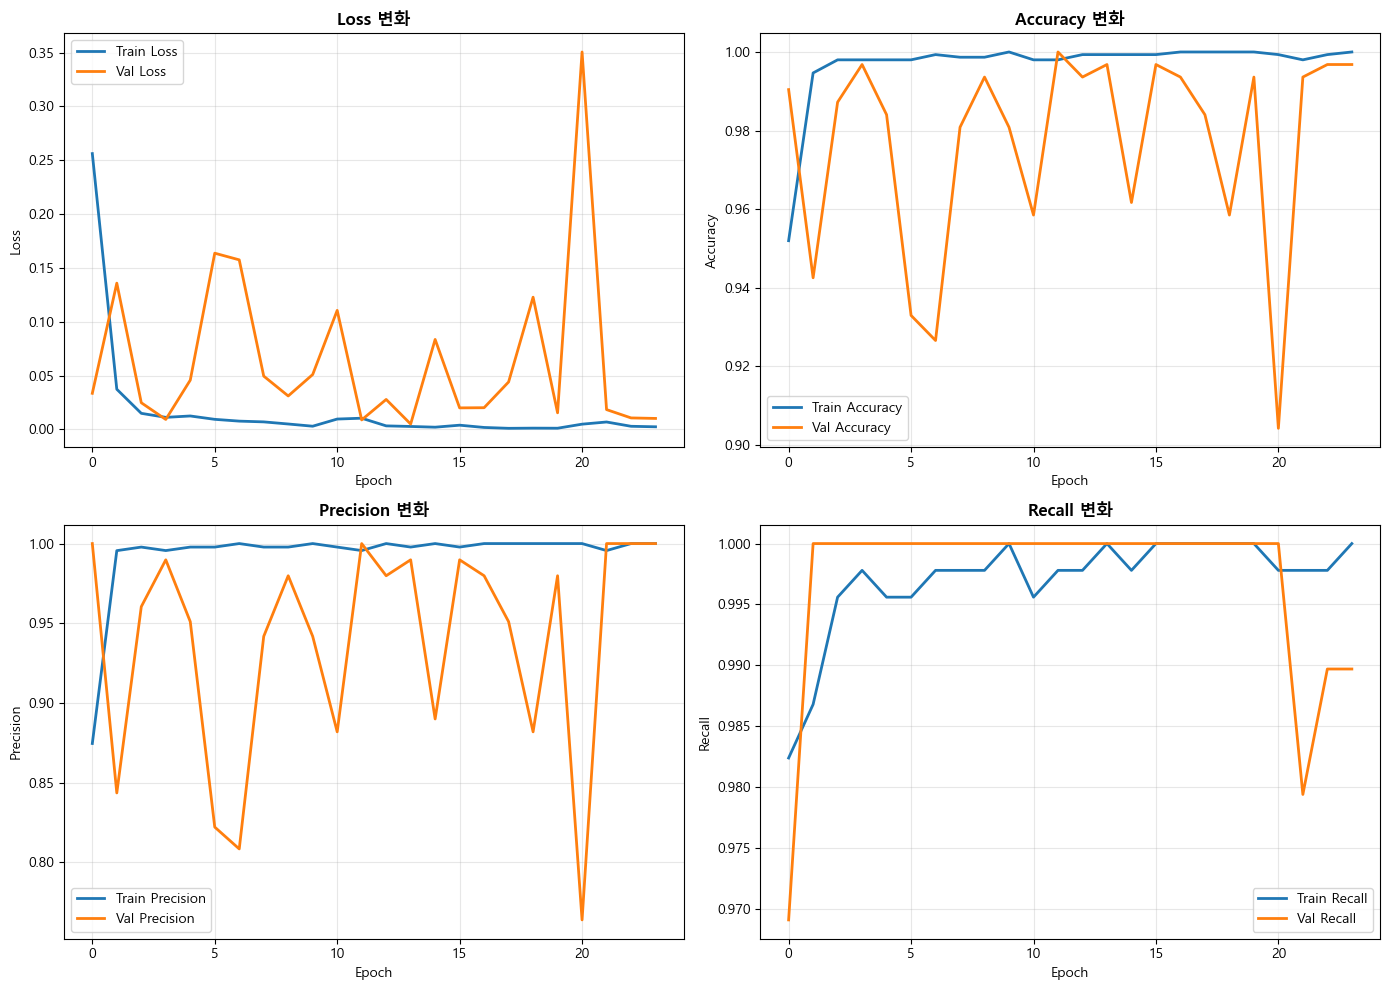

In [10]:
# 7. 모델 학습

# Early Stopping 설정
early_stop = EarlyStopping(
    monitor='val_loss',      # Val loss 모니터링
    patience=10,             # 10 epoch 개선 없으면 중단
    restore_best_weights=True,  # 최고 성능 모델로 복원
    verbose=1
)

# 학습 시작

history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)


# 학습 결과 요약
print("\n 최종 성능:")
final_train_loss = history.history['loss'][-1]
final_train_acc = history.history['accuracy'][-1]
final_val_loss = history.history['val_loss'][-1]
final_val_acc = history.history['val_accuracy'][-1]

print(f"  Train Loss: {final_train_loss:.4f}")
print(f"  Train Acc:  {final_train_acc:.4f}")
print(f"  Val Loss:   {final_val_loss:.4f}")
print(f"  Val Acc:    {final_val_acc:.4f}")

# 학습 곡선 시각화
print("\n학습 곡선 시각화")

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1) Loss
ax = axes[0, 0]
ax.plot(history.history['loss'], label='Train Loss', linewidth=2)
ax.plot(history.history['val_loss'], label='Val Loss', linewidth=2)
ax.set_title('Loss 변화', fontsize=12, fontweight='bold')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend()
ax.grid(True, alpha=0.3)

# 2) Accuracy
ax = axes[0, 1]
ax.plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
ax.plot(history.history['val_accuracy'], label='Val Accuracy', linewidth=2)
ax.set_title('Accuracy 변화', fontsize=12, fontweight='bold')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.legend()
ax.grid(True, alpha=0.3)

# 3) Precision
ax = axes[1, 0]
ax.plot(history.history['precision'], label='Train Precision', linewidth=2)
ax.plot(history.history['val_precision'], label='Val Precision', linewidth=2)
ax.set_title('Precision 변화', fontsize=12, fontweight='bold')
ax.set_xlabel('Epoch')
ax.set_ylabel('Precision')
ax.legend()
ax.grid(True, alpha=0.3)

# 4) Recall
ax = axes[1, 1]
ax.plot(history.history['recall'], label='Train Recall', linewidth=2)
ax.plot(history.history['val_recall'], label='Val Recall', linewidth=2)
ax.set_title('Recall 변화', fontsize=12, fontweight='bold')
ax.set_xlabel('Epoch')
ax.set_ylabel('Recall')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


Test 데이터 평가
------------------------------------------------------------
예측 중...
예측 완료!

Test 성능:
  Accuracy:  0.7683 (76.83%)
  Precision: 0.5731 (57.31%)
  Recall:    1.0000 (100.00%)

Confusion Matrix:
[[144  73]
 [  0  98]]

  TN (True Negative):  144 - 정상을 정상으로
  FP (False Positive): 73 - 정상을 고장으로 (거짓 경보)
  FN (False Negative): 0 - 고장을 정상으로 (놓침!) ⚠️
  TP (True Positive):  98 - 고장을 고장으로

Classification Report:
              precision    recall  f1-score   support

      정상 (0)       1.00      0.66      0.80       217
      고장 (1)       0.57      1.00      0.73        98

    accuracy                           0.77       315
   macro avg       0.79      0.83      0.76       315
weighted avg       0.87      0.77      0.78       315



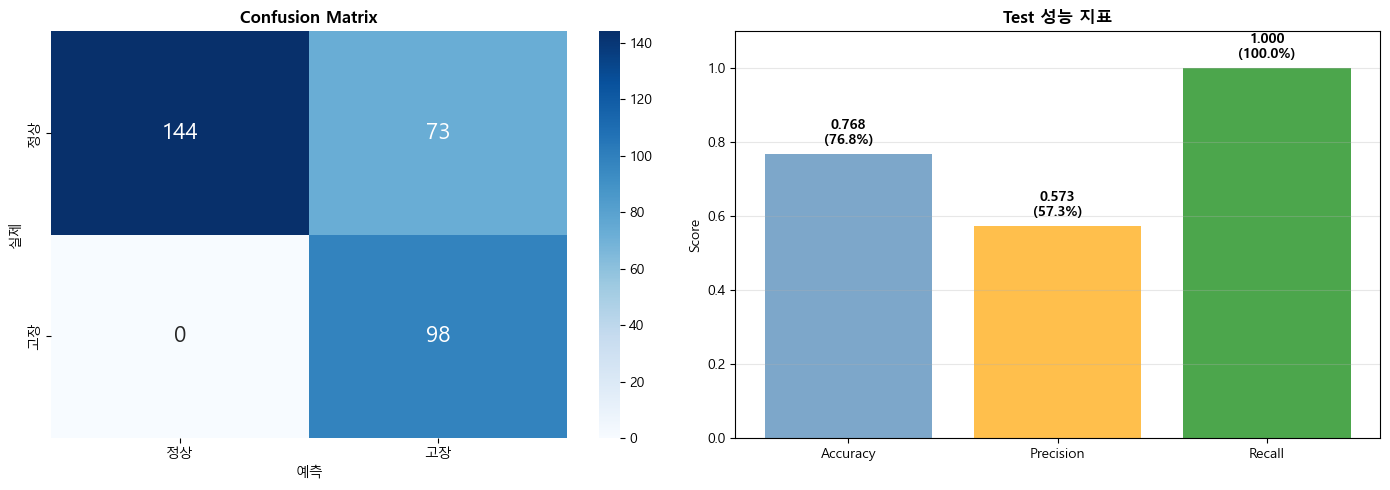


과적합 체크
Train Acc: 1.0000 (100.00%)
Val Acc:   0.9968 (99.68%)
Test Acc:  0.7683 (76.83%)

Train-Test 차이: 0.2317 (23.17%p)
과적합 가능성 높음 (차이 > 10%)


In [11]:
# 8. Test 평가

print("\nTest 데이터 평가")
print("-" * 60)

# 예측
print("예측 중...")
y_pred_prob = model.predict(X_test_scaled, verbose=0)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

print("예측 완료!")

# 성능 지표
from sklearn.metrics import classification_report, confusion_matrix

test_acc = accuracy_score(y_test, y_pred)
test_precision = precision_score(y_test, y_pred)
test_recall = recall_score(y_test, y_pred)

print("\nTest 성능:")
print(f"  Accuracy:  {test_acc:.4f} ({test_acc*100:.2f}%)")
print(f"  Precision: {test_precision:.4f} ({test_precision*100:.2f}%)")
print(f"  Recall:    {test_recall:.4f} ({test_recall*100:.2f}%)")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

print("\nConfusion Matrix:")
print(cm)
print(f"\n  TN (True Negative):  {cm[0,0]} - 정상을 정상으로")
print(f"  FP (False Positive): {cm[0,1]} - 정상을 고장으로 (거짓 경보)")
print(f"  FN (False Negative): {cm[1,0]} - 고장을 정상으로 (놓침!)")
print(f"  TP (True Positive):  {cm[1,1]} - 고장을 고장으로")

# 분류 리포트
print("\nClassification Report:")
print(classification_report(y_test, y_pred, 
                          target_names=['정상 (0)', '고장 (1)']))

# 시각화
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Confusion Matrix 히트맵
ax = axes[0]
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['정상', '고장'],
            yticklabels=['정상', '고장'],
            ax=ax, cbar=True, annot_kws={'size': 16})
ax.set_title('Confusion Matrix', fontsize=12, fontweight='bold')
ax.set_xlabel('예측')
ax.set_ylabel('실제')

# 성능 지표 비교
ax = axes[1]
metrics = ['Accuracy', 'Precision', 'Recall']
values = [test_acc, test_precision, test_recall]
colors = ['steelblue', 'orange', 'green']

bars = ax.bar(metrics, values, color=colors, alpha=0.7)
ax.set_ylim(0, 1.1)
ax.set_title('Test 성능 지표', fontsize=12, fontweight='bold')
ax.set_ylabel('Score')
ax.grid(True, alpha=0.3, axis='y')

# 값 표시
for bar, value in zip(bars, values):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.02,
            f'{value:.3f}\n({value*100:.1f}%)',
            ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# 과적합 체크
print("\n" + "=" * 60)
print("과적합 체크")
print("=" * 60)
print(f"Train Acc: {final_train_acc:.4f} ({final_train_acc*100:.2f}%)")
print(f"Val Acc:   {final_val_acc:.4f} ({final_val_acc*100:.2f}%)")
print(f"Test Acc:  {test_acc:.4f} ({test_acc*100:.2f}%)")

gap_train_test = final_train_acc - test_acc
print(f"\nTrain-Test 차이: {gap_train_test:.4f} ({gap_train_test*100:.2f}%p)")

if gap_train_test > 0.1:
    print("과적합 가능성 높음 (차이 > 10%)")
elif gap_train_test > 0.05:
    print("약간 과적합 (차이 5~10%)")
else:
    print("과적합 없음 (차이 < 5%)")


예측 결과 시각화
------------------------------------------------------------


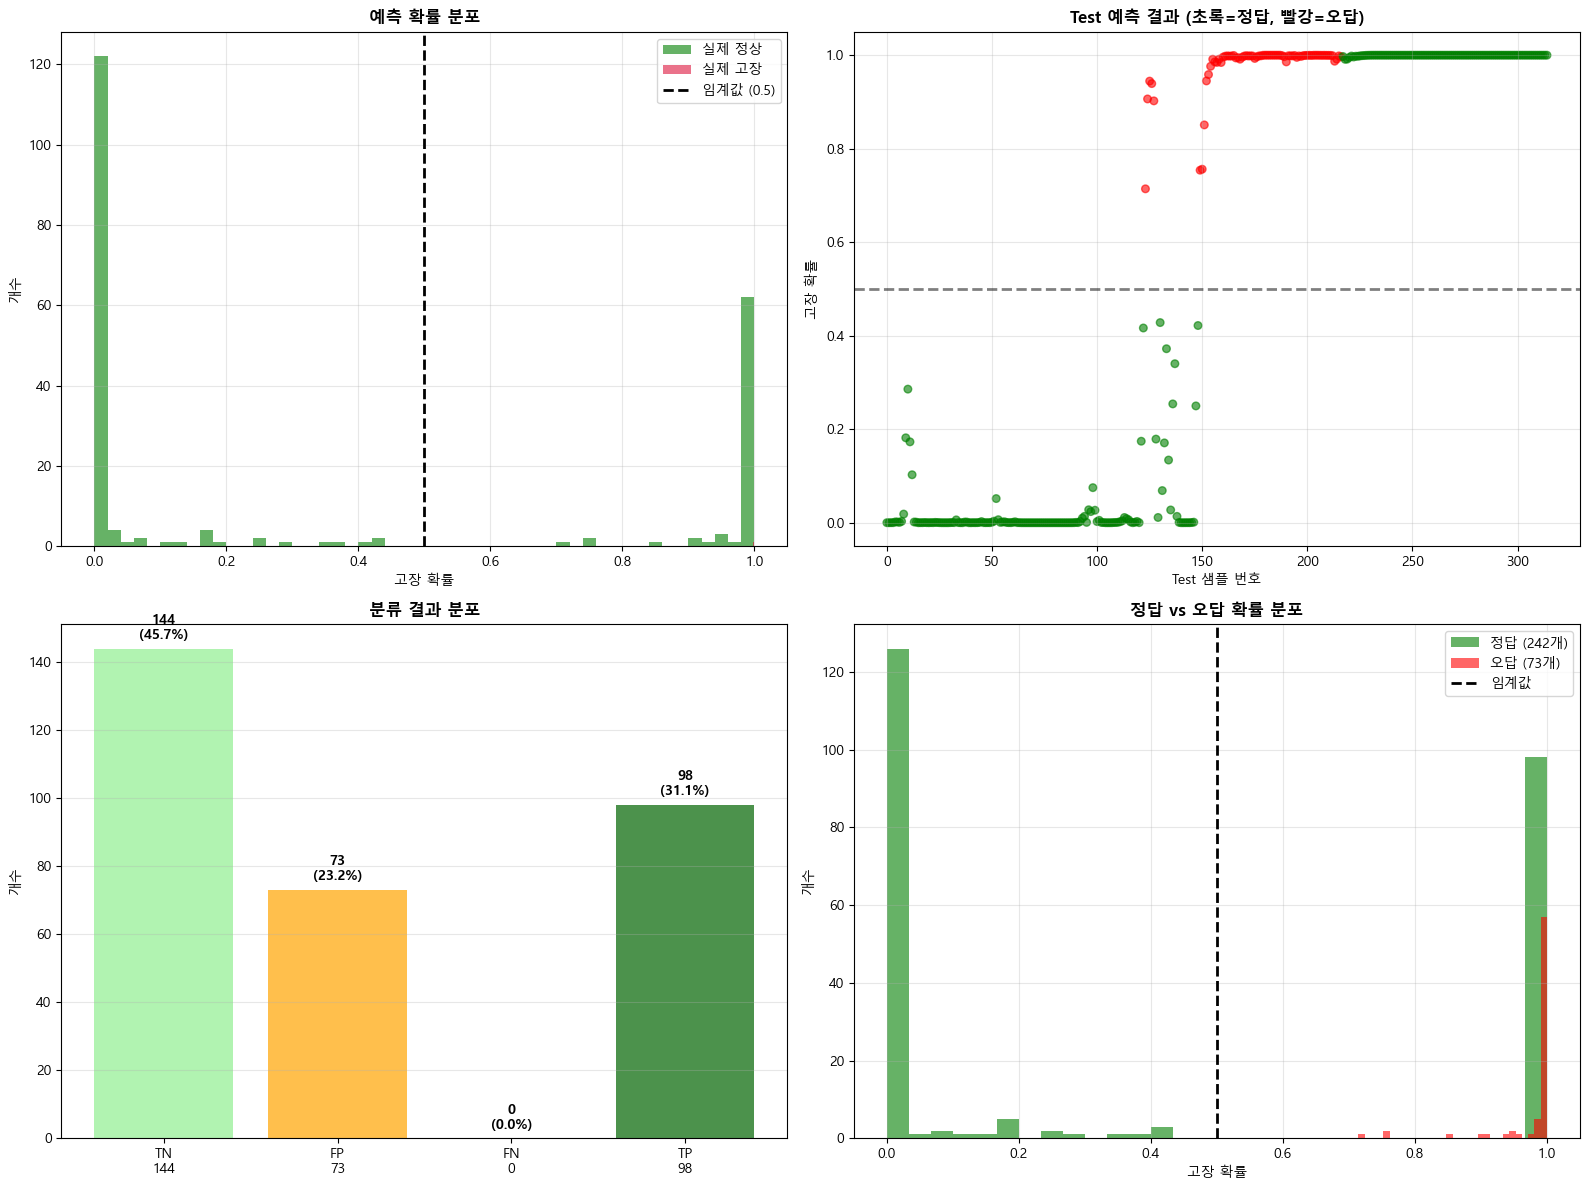


오분류 샘플 분석:
------------------------------------------------------------

False Positive (거짓 경보): 73개
  평균 확률: 0.979
  최대 확률: 1.000
  최소 확률: 0.714

False Negative (놓침): 0개 ⚠️

가장 애매한 예측 (0.5 근처):
  0.4~0.6 사이: 3개


In [12]:
# 9. 예측 시각화

print("\n예측 결과 시각화")
print("-" * 60)

# 예측 확률 분포
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 예측 확률 히스토그램
ax = axes[0, 0]

# 정상/고장 샘플별 확률 분포
normal_probs = y_pred_prob[y_test == 0].flatten()
failure_probs = y_pred_prob[y_test == 1].flatten()

ax.hist(normal_probs, bins=50, alpha=0.6, label='실제 정상', color='green')
ax.hist(failure_probs, bins=50, alpha=0.6, label='실제 고장', color='crimson')
ax.axvline(x=0.5, color='black', linestyle='--', linewidth=2, label='임계값 (0.5)')
ax.set_title('예측 확률 분포', fontsize=12, fontweight='bold')
ax.set_xlabel('고장 확률')
ax.set_ylabel('개수')
ax.legend()
ax.grid(True, alpha=0.3)

# 시간에 따른 예측
ax = axes[0, 1]

x = range(len(y_test))
colors = ['green' if actual == pred else 'red' 
          for actual, pred in zip(y_test, y_pred)]

scatter = ax.scatter(x, y_pred_prob.flatten(), c=colors, alpha=0.6, s=30)
ax.axhline(y=0.5, color='black', linestyle='--', linewidth=2, alpha=0.5)
ax.set_title('Test 예측 결과 (초록=정답, 빨강=오답)', fontsize=12, fontweight='bold')
ax.set_xlabel('Test 샘플 번호')
ax.set_ylabel('고장 확률')
ax.grid(True, alpha=0.3)

# 오분류 분석
ax = axes[1, 0]

# 오분류 타입
fp_mask = (y_test == 0) & (y_pred == 1)  # False Positive
fn_mask = (y_test == 1) & (y_pred == 0)  # False Negative
tp_mask = (y_test == 1) & (y_pred == 1)  # True Positive
tn_mask = (y_test == 0) & (y_pred == 0)  # True Negative

counts = [tn_mask.sum(), fp_mask.sum(), fn_mask.sum(), tp_mask.sum()]
labels = [f'TN\n{tn_mask.sum()}', f'FP\n{fp_mask.sum()}', 
          f'FN\n{fn_mask.sum()}', f'TP\n{tp_mask.sum()}']
colors_bar = ['lightgreen', 'orange', 'red', 'darkgreen']

bars = ax.bar(labels, counts, color=colors_bar, alpha=0.7)
ax.set_title('분류 결과 분포', fontsize=12, fontweight='bold')
ax.set_ylabel('개수')
ax.grid(True, alpha=0.3, axis='y')

# 값 표시
for bar, count in zip(bars, counts):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 2,
            f'{count}\n({count/len(y_test)*100:.1f}%)',
            ha='center', va='bottom', fontweight='bold')

# 오분류 샘플의 확률 분포
ax = axes[1, 1]

correct_probs = y_pred_prob[(y_test == y_pred).flatten()].flatten()
wrong_probs = y_pred_prob[(y_test != y_pred).flatten()].flatten()

ax.hist(correct_probs, bins=30, alpha=0.6, label=f'정답 ({len(correct_probs)}개)', 
        color='green')
ax.hist(wrong_probs, bins=30, alpha=0.6, label=f'오답 ({len(wrong_probs)}개)', 
        color='red')
ax.axvline(x=0.5, color='black', linestyle='--', linewidth=2, label='임계값')
ax.set_title('정답 vs 오답 확률 분포', fontsize=12, fontweight='bold')
ax.set_xlabel('고장 확률')
ax.set_ylabel('개수')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 오분류 샘플 분석
print("\n오분류 샘플 분석:")
print("-" * 60)

print(f"\nFalse Positive (거짓 경보): {fp_mask.sum()}개")
if fp_mask.sum() > 0:
    fp_probs = y_pred_prob[fp_mask].flatten()
    print(f"  평균 확률: {fp_probs.mean():.3f}")
    print(f"  최대 확률: {fp_probs.max():.3f}")
    print(f"  최소 확률: {fp_probs.min():.3f}")

print(f"\nFalse Negative (놓침): {fn_mask.sum()}개")
if fn_mask.sum() > 0:
    fn_probs = y_pred_prob[fn_mask].flatten()
    print(f"  평균 확률: {fn_probs.mean():.3f}")
    print(f"  최대 확률: {fn_probs.max():.3f}")
    print(f"  최소 확률: {fn_probs.min():.3f}")

# 가장 확신 없는 예측
print("\n가장 애매한 예측 (0.5 근처):")
ambiguous_mask = (y_pred_prob > 0.4) & (y_pred_prob < 0.6)
print(f"  0.4~0.6 사이: {ambiguous_mask.sum().sum()}개")

In [ ]:
# 10. 모델 저장 (최신 Keras 형식)

import os
import joblib

# 저장 경로
model_save_path = '../models/lstm_model.keras'

# 폴더가 없으면 생성
os.makedirs(os.path.dirname(model_save_path), exist_ok=True)

# LSTM 모델 저장 (최신 Native Keras 형식)
model.save(model_save_path)
print(f"✅ LSTM 모델 저장 완료: {model_save_path}")
print(f"   형식: Native Keras (.keras) - TensorFlow 2.4+ 권장")

# 학습 히스토리 저장
history_save_path = '../models/lstm_history.pkl'
with open(history_save_path, 'wb') as f:
    joblib.dump(history.history, f)
print(f"✅ 학습 히스토리 저장 완료: {history_save_path}")

print(f"\n📁 저장된 파일들:")
print(f"   🔹 모델: {model_save_path} (Native Keras)")
print(f"   🔹 히스토리: {history_save_path} (pickle)")

print(f"\n📌 참고: 스케일러는 공통 파일 사용")
print(f"   🔹 스케일러: ../models/scaler.pkl (모든 모델 공유)")

print(f"\n💡 모델 로드 방법:")
print(f"   from tensorflow import keras")
print(f"   import joblib")
print(f"   model = keras.models.load_model('{model_save_path}')")
print(f"   scaler = joblib.load('../models/scaler.pkl')")
print(f"   history = joblib.load('{history_save_path}')")